## Video 6 - Building an RNN Model with Word Embedding

In [2]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Then let's read the dataset and check their shape.

In [44]:
# read the dataset
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [45]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

Next, we create a function named preprocess_text just like before and apply it on the dataframes.

In [46]:
import re

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []
    
    # Keep only letters and whitespaces
    pattern = f"[a-zA-Z\s]"
    text = ''.join(re.findall(pattern, text))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    return tokens


In [47]:
#apply the preprocess text to 
train['user_review'] = train.user_review.apply(preprocess_text)
validation['user_review'] = validation.user_review.apply(preprocess_text)
test['user_review'] = test.user_review.apply(preprocess_text)

In [48]:
#check the head of train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0


As you can see, we have achieved our desired result.

In [49]:
# Fetch embeddings
word2vec_model = Word2Vec(sentences=train.user_review.values.tolist(), 
                          vector_size=100, min_count=1, workers=4)

# Get vocabulary size
vocab_size = len(word2vec_model.wv)
print(vocab_size)

81493


In [50]:
# Convert text to Word2Vec embeddings
def text_to_embeddings(text, word2vec_model, seq_length):
    embeddings = []
    
    for i, word in enumerate(text):
        if word in word2vec_model.wv:
            if i == seq_length:
                break
            embeddings.append(word2vec_model.wv[word])
        else:
            continue
        
    # Padding the sequences
    if len(embeddings) < seq_length:
        zero_padding = [np.zeros(word2vec_model.vector_size) \
                        for _ in range(seq_length - len(embeddings))]

        embeddings = embeddings + zero_padding

    return embeddings[:seq_length]

#### Explanation-
This function, text_to_embeddings, converts a given text into a sequence of embeddings using a pre-trained Word2Vec model. Here's a detailed breakdown of its operations:

1. __Initialization__: The function initializes an empty list called embeddings to store the word vectors.

2. __Iterating Over Words__: It loops over each word in the text. The enumeration provides both the index i and the word itself.

3. __Word Embedding Lookup__:
    - If the current word exists in the Word2Vec model's vocabulary (word2vec_model.wv), its corresponding embedding is retrieved and appended to the embeddings list.
    - If the word is not in the model's vocabulary, it is skipped (continue), effectively ignoring out-of-vocabulary words.
    - The loop breaks when the number of embeddings equals the specified seq_length, ensuring that the number of word vectors does not exceed the desired sequence length.

4. __Padding__:
- After processing all words, if the number of obtained embeddings is less than seq_length, the function pads the sequence with zero vectors. Each zero vector has the same dimensionality as the Word2Vec embeddings (word2vec_model.vector_size).
- Zero padding is added to the end of the embeddings list until its length matches seq_length.

5. __Return__: The function returns the embeddings list, which now contains a sequence of word vectors of length seq_length. If the initial number of embeddings exceeds seq_length, it truncates the list to return exactly seq_length embeddings.

In [51]:
# Prepare data
def prepare_data(reviews, labels, word2vec_model):
    X = [text_to_embeddings(review, word2vec_model, 100) for review in reviews]
    X = [torch.tensor(embeddings, dtype=torch.float32) for embeddings in X]
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

In [52]:
# Prepare data
X_train, y_train = prepare_data(train.user_review, train.user_suggestion,
                    word2vec_model)

X_val, y_val = prepare_data(validation.user_review, validation.user_suggestion,
                    word2vec_model)

In [53]:
# Define hyperparameters
input_size = word2vec_model.vector_size
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 64
dropout_rate = 0.5
leaky_relu_slope = 0.1

In [54]:
# Create DataLoader
train_data = TensorDataset(torch.stack(X_train), y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [55]:
# Create DataLoader
val_data = TensorDataset(torch.stack(X_val), y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

#### RNN Model with Word Embedding

In [56]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.leaky_relu = nn.LeakyReLU()  # Leaky ReLU activation layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)
        # Apply Leaky ReLU to the outputs of the RNN layer
        out = self.leaky_relu(out)
        out = self.dropout(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        out = self.sigmoid(out)
        return out


In [57]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size, hidden_size, output_size, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Epoch 1/30, Loss: 0.6822, Val Loss: 0.6929
Epoch 2/30, Loss: 0.6859, Val Loss: 0.6842
Epoch 3/30, Loss: 0.6841, Val Loss: 0.6848
Epoch 4/30, Loss: 0.6804, Val Loss: 0.6883
Epoch 5/30, Loss: 0.6873, Val Loss: 0.6829
Epoch 6/30, Loss: 0.6828, Val Loss: 0.6869
Epoch 7/30, Loss: 0.6838, Val Loss: 0.6832
Epoch 8/30, Loss: 0.6823, Val Loss: 0.6838
Early stopped at 8
Lowest Validation Loss: 0.6829 at Epoch 5


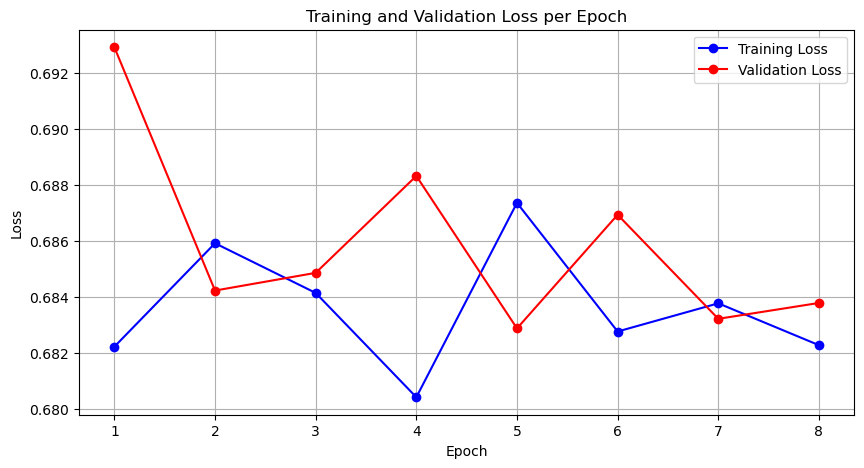

Best Model Training Accuracy: 56.99502153605191%
Best Model Validation Accuracy: 56.669276951187676%


In [59]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# Video 8 - Advanced RNN Structures

#### Using Multilayered Bi-Directional RNN

In [60]:
# Define num_layers
num_layers = 2

In [61]:
class SentimentBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5):
        super(SentimentBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Using RNN for the recurrent layer
        self.bi_rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        # Doubling the output size because of bidirectionality
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Initialize hidden state for RNN
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the RNN
        out, _ = self.bi_rnn(x, h0)
        # Apply Leaky ReLU activation
        out = nn.functional.leaky_relu(out)
        out = self.dropout(out)
        # Get the last time step's output for the fully connected layer
        out = self.fc(out[:, -1, :])
        # Apply sigmoid to the output layer
        out = torch.sigmoid(out)
        return out

In [62]:
# Initialize model, loss function, and optimizer
model = SentimentBiRNN(input_size, hidden_size, output_size, num_layers, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/30, Loss: 0.6869, Val Loss: 0.6853
Epoch 2/30, Loss: 0.6825, Val Loss: 0.6904
Epoch 3/30, Loss: 0.6830, Val Loss: 0.6928
Epoch 4/30, Loss: 0.6822, Val Loss: 0.6828
Epoch 5/30, Loss: 0.6812, Val Loss: 0.6848
Epoch 6/30, Loss: 0.6790, Val Loss: 0.6810
Epoch 7/30, Loss: 0.6805, Val Loss: 0.6838
Epoch 8/30, Loss: 0.6782, Val Loss: 0.6774
Epoch 9/30, Loss: 0.6814, Val Loss: 0.6798
Epoch 10/30, Loss: 0.6784, Val Loss: 0.6829
Epoch 11/30, Loss: 0.6793, Val Loss: 0.6821
Early stopped at 11
Lowest Validation Loss: 0.6774 at Epoch 8


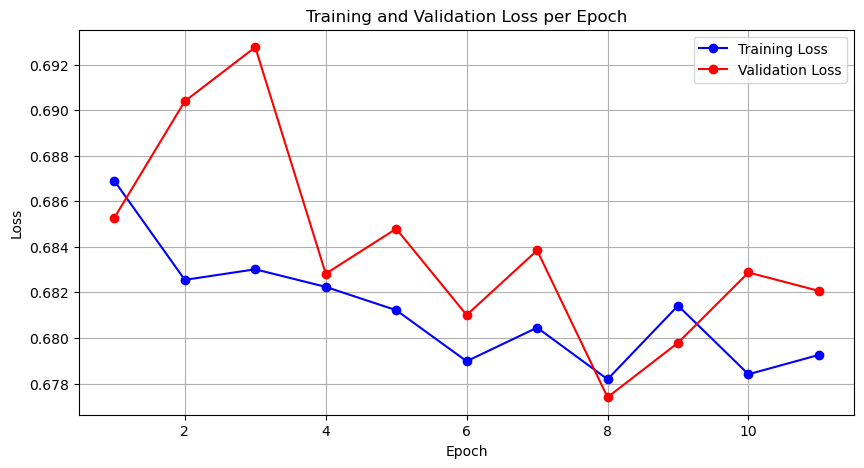

Best Model Training Accuracy: 59.45069083179504%
Best Model Validation Accuracy: 57.16523101018011%


In [63]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bidirectional_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bidirectional_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

### Limitations of RNN

During training, RNNs use __Backward Propagation through time__. If the sequence of data is long, the gradients can become extremely small, effectively preventing the network from learning. This is known as the vanishing gradient problem. If you remember we have already covered vanishing and exploding gradients in our previous deep learning course.

Due to this vanishing gradient problem, standard RNNs often fail to capture long-term dependencies in the data. For example, in a long sentence or paragraph, the network might struggle to connect a subject at the beginning with a verb much later in the sentence. 

Simply speaking, RNN is only good at remembering recent data and has a short term memory. 

For example, in the sentence : "Kyle went to the store to buy a loaf of bread because he was hungry." The network needs to understand the long-range dependency between "Kyle" and "he" to understand both of them are the same.
If the vanishing gradient problem occurs, the network might struggle to learn this dependency as the gradient carrying information about "Kyle" becomes very small by the time it reaches the layers responsible for connecting the word "he".

To address these vanishing gradient problems and capture long term  dependencies or memories in the data more effectively, RNN is updated and a new advanced types RNN - LSTM and GRU is introduced. Let’s look at LSTM first in the next video.

# Video 10 - Using Bi-Directional GRU Model

In [64]:
class SentimentGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5, leaky_relu_slope=0.1):
        super(SentimentGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, 
                          bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Output size is doubled because of bidirectionality
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU
        out, _ = self.gru(x, h0)
        # Apply Leaky ReLU activation
        out = nn.functional.leaky_relu(out)
        # Apply dropout
        out = self.dropout(out)
        # Use only the last output for the fully connected layer
        out = self.fc(out[:, -1, :])
        # Apply sigmoid to the output layer
        out = torch.sigmoid(out)
        return out

In [65]:
# Initialize model, loss function, and optimizer
model = SentimentGRU(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/30, Loss: 0.6712, Val Loss: 0.6911
Epoch 2/30, Loss: 0.5477, Val Loss: 0.4444
Epoch 3/30, Loss: 0.4313, Val Loss: 0.4006
Epoch 4/30, Loss: 0.3815, Val Loss: 0.4000
Epoch 5/30, Loss: 0.3441, Val Loss: 0.4031
Epoch 6/30, Loss: 0.3124, Val Loss: 0.4473
Epoch 7/30, Loss: 0.2796, Val Loss: 0.4168
Early stopped at 7
Lowest Validation Loss: 0.4000 at Epoch 4


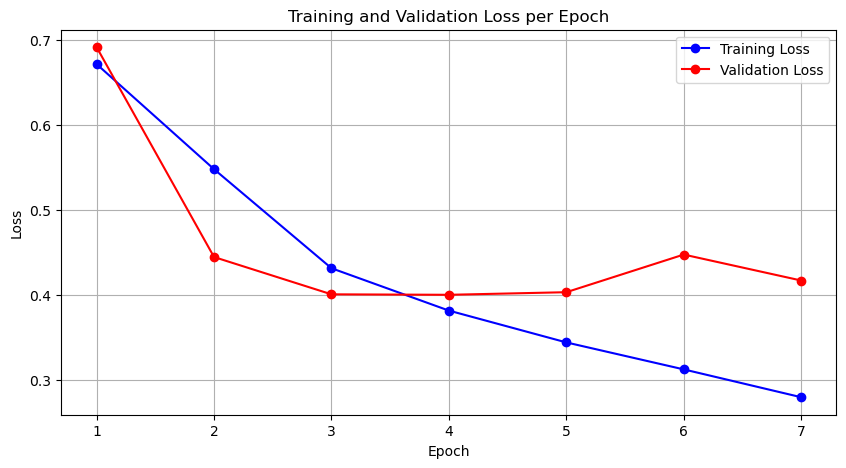

Best Model Training Accuracy: 86.12183252223528%
Best Model Validation Accuracy: 82.51109370921431%


In [66]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bi_gru_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bi_gru_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# Video 12 - Bidirectional LSTM Model

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5, leaky_relu_slope=0.1):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.leaky_relu_slope = leaky_relu_slope

        # # Create LSTM layers with nn.LSTM

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Define dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer (output size is doubled for bidirectionality)
        self.fc = nn.Linear(hidden_size * 2, output_size)

        # Sigmoid activation for output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)

        outputs, _ = self.lstm(x, (h_0, c_0))
        
        outputs = F.leaky_relu(outputs, negative_slope=self.leaky_relu_slope)  # Leaky ReLU activation

        # Apply dropout and fully connected layer
        outputs = self.dropout(outputs)
        out = self.fc(outputs[:, -1, :])

        # Sigmoid activation for output
        out = self.sigmoid(out)
        return out


In [78]:
# Initialize model, loss function, and optimizer
model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/30, Loss: 0.6821, Val Loss: 0.6848
Epoch 2/30, Loss: 0.6721, Val Loss: 0.6326
Epoch 3/30, Loss: 0.5772, Val Loss: 0.5304
Epoch 4/30, Loss: 0.4874, Val Loss: 0.4482
Epoch 5/30, Loss: 0.4278, Val Loss: 0.4468
Epoch 6/30, Loss: 0.3973, Val Loss: 0.4118
Epoch 7/30, Loss: 0.3718, Val Loss: 0.4264
Epoch 8/30, Loss: 0.3446, Val Loss: 0.4750
Epoch 9/30, Loss: 0.3201, Val Loss: 0.4160
Early stopped at 9
Lowest Validation Loss: 0.4118 at Epoch 6


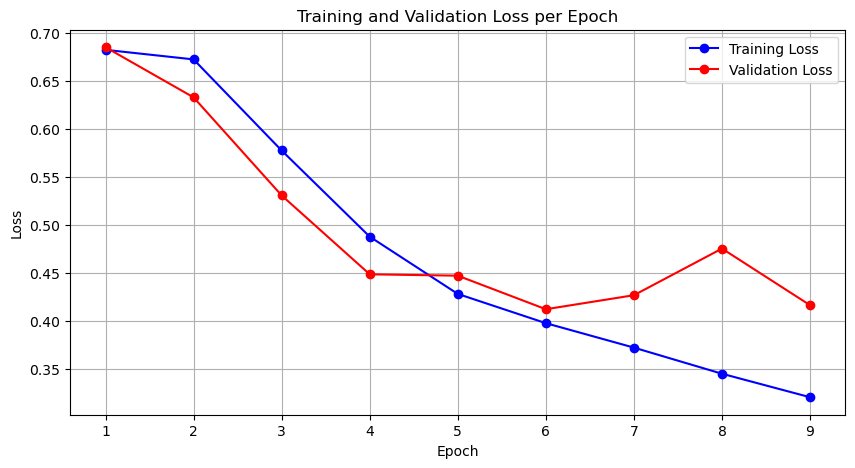

Best Model Training Accuracy: 85.0310454774291%
Best Model Validation Accuracy: 81.33646567475854%


In [69]:
#Training loop
import matplotlib.pyplot as plt

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
patience = 0
max_patience = 3  # Maximum epochs to wait for improvement

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'bi_lstm_best_model.pth')  # Save the best model
        patience = 0   
    else:
        patience += 1

    if patience >= max_patience:
        print(f'Early stopped at {epoch+1}')
        break  # Stop training

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, (len(losses)+1)), losses, 'bo-', label='Training Loss')
plt.plot(range(1, (len(losses)+1)), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('bi_lstm_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')

# Performance on Test Data

In [70]:
X_test, y_test = prepare_data(test.user_review, test.user_suggestion,
                    word2vec_model)

In [71]:
test_data = TensorDataset(torch.stack(X_test), y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [83]:
# Initialize model, loss function, and optimizer
model = SentimentGRU(input_size, hidden_size, output_size, num_layers, dropout_rate, leaky_relu_slope)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [84]:
model.load_state_dict(torch.load('bi_gru_best_model.pth'))

<All keys matched successfully>

In [85]:
# model.load_state_dict(torch.load('bi_lstm__best_model.pth'))

In [86]:
# model.load_state_dict(torch.load('bi_gru_best_model.pth'))
test_accuracy = calculate_accuracy(test_loader)
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 83.24197337509788%
